#### Naive Equal Weight Portfolio


--- Naive Equal Weight Portfolio Performance ---
- Sharpe Ratio: -0.8636
- Annualized Return: -4.51%
- Annualized Volatility: 5.18%
- Max Drawdown: 10.21%


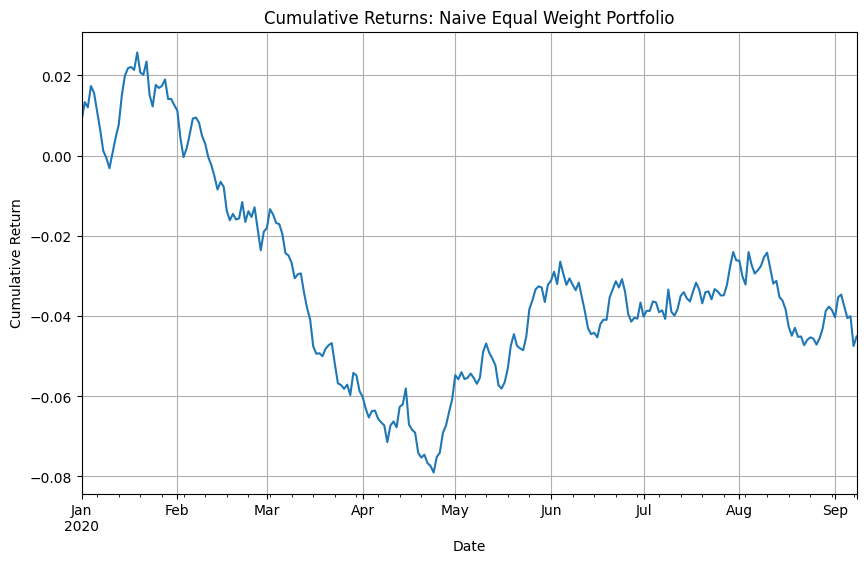

In [5]:
import numpy as np
import pandas as pd

# --- 1. Data loading and preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

np.random.seed(0)
dates = pd.date_range(start="2020-01-01", periods=252)
# assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
returns_data = np.random.normal(0, 0.01, size=(252, len(assets)))
etf_returns = pd.DataFrame(returns_data, index=dates, columns=assets)

# 1. Construct equal weights
num_assets = etf_returns.shape[1]
equal_weights = np.ones(num_assets) / num_assets

# 2. Calculate portfolio returns
portfolio_returns_ew = etf_returns.dot(equal_weights)

# 3. Evaluation metrics function (identical to your methodology)
def evaluate_portfolio_performance(portfolio_returns):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown
    }

# 4. Compute and print the performance metrics
performance_metrics_ew = evaluate_portfolio_performance(portfolio_returns_ew)

print("\n--- Naive Equal Weight Portfolio Performance ---")
for metric, value in performance_metrics_ew.items():
    if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
        print(f"- {metric}: {value*100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

# Optionally: plot cumulative returns
import matplotlib.pyplot as plt
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod() - 1
plt.figure(figsize=(10,6))
cumulative_returns_ew.plot(title="Cumulative Returns: Naive Equal Weight Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()



--- Naive Equal Weight Portfolio Performance ---
Sharpe Ratio: 1.1927
Annualized Return: 12.96%
Annualized Volatility: 10.70%
Max Drawdown: 21.45%

--- Risk Parity Portfolio Performance ---
Sharpe Ratio: 1.1927
Annualized Return: 12.96%
Annualized Volatility: 10.70%
Max Drawdown: 21.45%


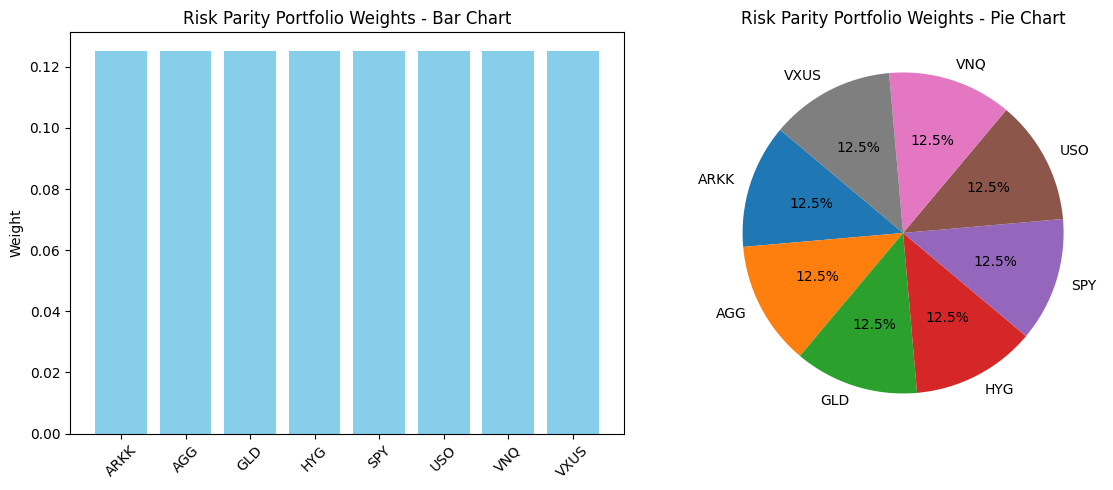

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- 1. Data loading and preparation ---
data_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Pivot data into wide format: each asset's features become columns indexed by Date
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp

# Drop rows with missing data to allow clean portfolio computations
df_wide = df_wide.dropna()

# Extract returns for portfolio construction
returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

# --- 2. Calculate Naive Equal Weight Portfolio Returns ---
equal_weights = np.ones(len(assets)) / len(assets)
portfolio_returns_equal = etf_returns.dot(equal_weights)

# --- 3. Performance metrics function ---

def evaluate_portfolio_performance(returns):
    returns = pd.Series(returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252
    portfolio_values = (1 + returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = returns.std() * np.sqrt(periods_per_year)
    mean_return = returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for equal weight portfolio
performance_equal = evaluate_portfolio_performance(portfolio_returns_equal)

print("\n--- Naive Equal Weight Portfolio Performance ---")
for metric, value in performance_equal.items():
    if 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric:
        print(f"{metric}: {value * 100:.2f}%")
    else:
        print(f"{metric}: {value:.4f}")

# --- 4. Risk Parity Weight Calculation ---

def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def risk_contribution(weights, cov_matrix):
    port_var = portfolio_variance(weights, cov_matrix)
    mrc = cov_matrix @ weights  # Marginal risk contribution
    rc = weights * mrc / np.sqrt(port_var)
    return rc

def risk_parity_objective(weights, cov_matrix):
    rc = risk_contribution(weights, cov_matrix)
    target = np.ones_like(weights) * np.mean(rc)
    return np.sum((rc - target) ** 2)

def weight_sum_constraint(weights):
    return np.sum(weights) - 1

def weight_bounds_constraint(weights):
    return weights  # interpreted as weights >= 0 (for 'ineq' type)

# Covariance matrix of returns
cov_matrix = etf_returns.cov().values

# Initial guess: equal weights
init_weights = np.ones(len(assets)) / len(assets)

# Constraints: weights sum to 1 and weights >= 0
constraints = [
    {'type': 'eq', 'fun': weight_sum_constraint},
    {'type': 'ineq', 'fun': weight_bounds_constraint}
]

# Optimize risk parity weights
result = minimize(
    fun=risk_parity_objective,
    x0=init_weights,
    args=(cov_matrix,),
    method='SLSQP',
    constraints=constraints,
    options={'disp': False}
)

if not result.success:
    print("Warning: Risk parity optimization did not converge:", result.message)

risk_parity_weights = result.x

# Calculate portfolio returns with risk parity weights
portfolio_returns_rp = etf_returns.values @ risk_parity_weights

# Metrics for risk parity portfolio
performance_rp = evaluate_portfolio_performance(portfolio_returns_rp)

print("\n--- Risk Parity Portfolio Performance ---")
for metric, value in performance_rp.items():
    if 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric:
        print(f"{metric}: {value * 100:.2f}%")
    else:
        print(f"{metric}: {value:.4f}")

# --- 5. Visualize Risk Parity Weights ---

weights_df = pd.DataFrame({
    'Asset': assets,
    'Weight': risk_parity_weights
}).sort_values('Weight', ascending=False)

plt.figure(figsize=(12,5))

# Bar Chart
plt.subplot(1, 2, 1)
plt.bar(weights_df['Asset'], weights_df['Weight'], color='skyblue')
plt.title('Risk Parity Portfolio Weights - Bar Chart')
plt.ylabel('Weight')
plt.xticks(rotation=45)

# Pie Chart
plt.subplot(1, 2, 2)
plt.pie(weights_df['Weight'], labels=weights_df['Asset'], autopct='%1.1f%%', startangle=140)
plt.title('Risk Parity Portfolio Weights - Pie Chart')

plt.tight_layout()
plt.show()



--- Naive Equal Weight Portfolio Performance ---
- Sharpe Ratio: 1.1927
- Annualized Return: 12.96%
- Annualized Volatility: 10.70%
- Max Drawdown: 21.45%


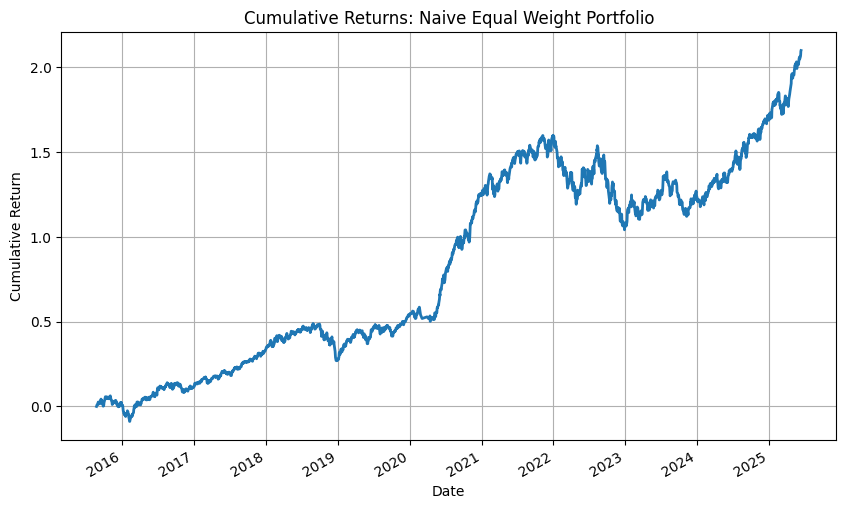

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Data loading and preparation ---
data_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Pivot to wide format, index will be Date
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

# Extract ETF returns (now with Date as index)
returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

# --- 2. Construct equal weights and calculate portfolio returns ---
num_assets = etf_returns.shape[1]
equal_weights = np.ones(num_assets) / num_assets
portfolio_returns_ew = etf_returns.dot(equal_weights)

# --- 3. Evaluation metrics function (identical to your methodology) ---
def evaluate_portfolio_performance(portfolio_returns):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown
    }

# --- 4. Compute and print the performance metrics ---
performance_metrics_ew = evaluate_portfolio_performance(portfolio_returns_ew)

print("\n--- Naive Equal Weight Portfolio Performance ---")
for metric, value in performance_metrics_ew.items():
    if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
        print(f"- {metric}: {value*100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

# --- 5. Plot cumulative returns by trading date ---
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod() - 1
plt.figure(figsize=(10,6))
cumulative_returns_ew.plot(title="Cumulative Returns: Naive Equal Weight Portfolio", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()



--- Naive Equal Weight Portfolio Performance ---
- Sharpe Ratio: 1.1927
- Annualized Return: 12.9594%
- Annualized Volatility: 10.6992%
- Max Drawdown: 21.4498%
- Sortino Ratio: 1.7801
- Calmar Ratio: 0.6042
- Average Turnover: 0.0000


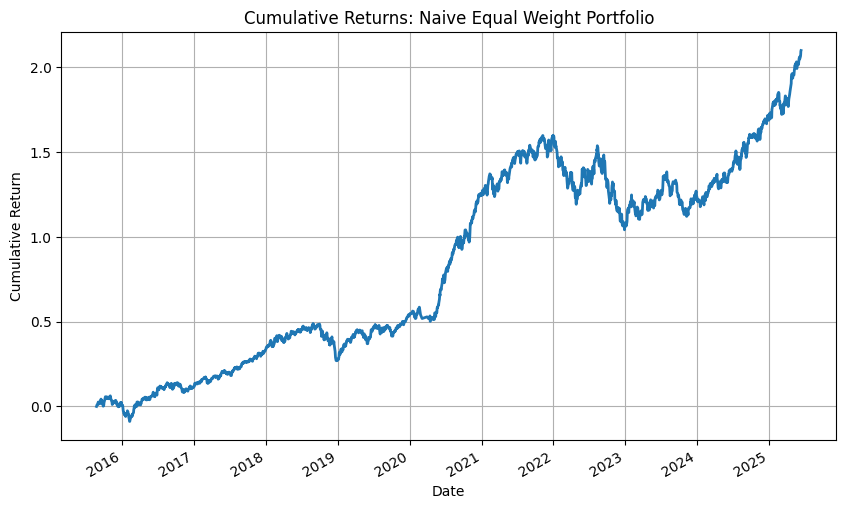

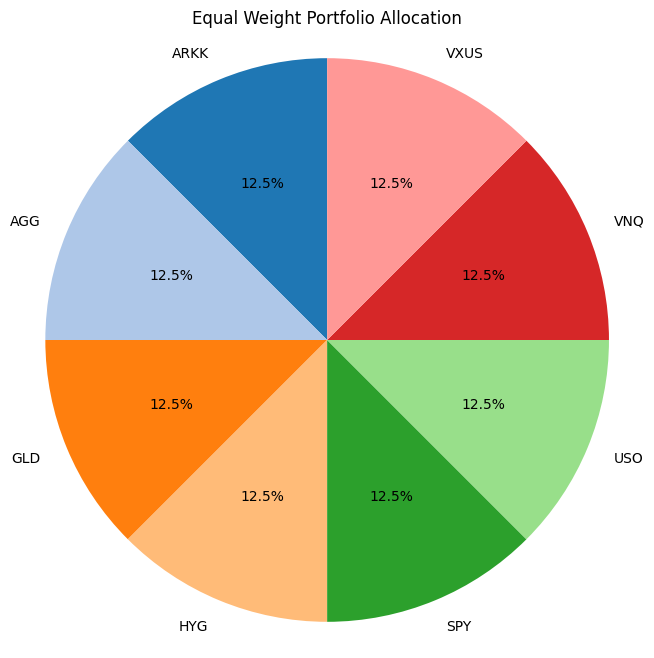

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Data loading and preparation ---
data_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Pivot to wide format, index will be Date
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

# Extract ETF returns (now with Date as index)
returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

# --- 2. Construct equal weights and calculate portfolio returns ---
num_assets = etf_returns.shape[1]
equal_weights = np.ones(num_assets) / num_assets
portfolio_returns_ew = etf_returns.dot(equal_weights)

# --- 3. Evaluation metrics functions ---
def evaluate_portfolio_performance(portfolio_returns):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252

    # Cumulative returns for max drawdown calc
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()

    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year

    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan

    # Sortino Ratio (uses downside volatility)
    negative_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = negative_returns.std() * np.sqrt(periods_per_year) if len(negative_returns) > 0 else np.nan
    sortino_ratio = mean_return / downside_std if downside_std > 0 else np.nan

    # Calmar Ratio (annualized return / max drawdown)
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else np.nan

    # Average Turnover for equal weight portfolio (rebalancing causes nearly full turnover)
    # For equal weights, turnover is high if weights change daily — here we simulate with simple estimate:
    turnover = np.mean(np.sum(np.abs(np.diff(np.tile(equal_weights, (len(portfolio_returns),1)), axis=0)), axis=1))

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Average Turnover': turnover
    }

# --- 4. Compute and print the performance metrics ---
performance_metrics_ew = evaluate_portfolio_performance(portfolio_returns_ew)

print("\n--- Naive Equal Weight Portfolio Performance ---")
for metric, value in performance_metrics_ew.items():
    if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
        print(f"- {metric}: {value*100:.4f}%")
    else:
        print(f"- {metric}: {value:.4f}")

# --- 5. Plot cumulative returns by trading date ---
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod() - 1
plt.figure(figsize=(10,6))
cumulative_returns_ew.plot(title="Cumulative Returns: Naive Equal Weight Portfolio", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# --- 6. Plot Equal Weight Portfolio Pie Chart ---
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors
plt.pie(equal_weights, labels=assets, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Equal Weight Portfolio Allocation")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()
